In [1]:
import numpy as np 
# import tensorflow as tf
import matplotlib.pyplot as plt #绘图库
import h5py #用于读写HDF5文件，这种文件格式常用于保存大规模科学计算数据
from datetime import datetime #处理日期和时间
from scipy.interpolate import interp1d #一维数据插值，可根据已有数据点构造插值函数
import matplotlib.gridspec as gridspec #用于灵活地创建网格布局的子图，便于复杂布局的绘图
from mpl_toolkits.axes_grid1 import make_axes_locatable #提供高级轴管理工具，主要用于精细地控制子图和颜色条的位置及大小

Functions

In [2]:
#给输入信号添加高斯噪声，参数sig为输入信号，输出带噪声的信号
def add_noise(sig):
    #设置目标信噪比(signal-to-noise ratio, SNR)
    SNR_target = 500
    sig_avg_db = 10 * np.log10(np.mean(sig)) #将输入信号sig的均值转换为分贝(dB)单位
    noise_avg = 10 ** ((sig_avg_db - SNR_target)/ 10) #根据目标信噪比计算噪声的均方值
    #生成高斯噪声，均值为0，方差为noise_avg，长度与输入信号相同
    mean_noise = 0 
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg), len(sig))
    #输入信号与噪声相加得到含噪声的信号
    signal_noise = sig + noise
    
    return signal_noise

#初始化神经网络的预测
def ini_net( x, t):
    #将输入数据x和t连接后进行归一化处理
    X = 2.0 * (tf.concat([x, t], 1) - ini_LB) / (ini_UB - ini_LB) - 1.0
    #获取神经网络的层数
    num_layers = len(ini_weights)
    #H为归一化后的神经网络输入
    H = X
    #循环遍历神经网络的每一层
    for l in range(0, num_layers - 1):
        W = ini_weights[l] #获取第l层的权重
        b = ini_biases[l] #获取第l层的偏置
        H = tf.tanh(tf.add(tf.matmul(H, W), b)) #计算第l层的输出，激活函数为tanh
    #输出层的计算，五激活函数
    W = ini_weights[-1] 
    b = ini_biases[-1]
    out = tf.add(tf.matmul(H, W), b)
    #网络的两个输出分别为u和h
    u = out[:, 0:1]
    h = out[:, 1:2]


    return u, h


#计算预测值与真实值之间的误差和均方根误差（RMSE），输入是true真实值，picted预测值，label标签，最后函数预测值和真实值打印误差和均方根误差
def calculate_error_and_rmse(true, picted, label):
    error = np.linalg.norm(true - picted, 2) / np.linalg.norm(true, 2) #计算预测值和真实值之间的相对误差
    rmse = np.sqrt(((true - picted) ** 2).mean()) #计算真实值和预测值之间的均方根误差
    #打印误差和均方根误差
    print(f'Error_{label}: {error:e}') 
    print(f'RMSE_{label}: {rmse:.3f} m')

#统一坐标轴字体大小的函数
def set_font_size(ax, fontsize):
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)

#用于在给定的matplotlib图中创建带有等高线填充图（contour plot）和颜色条的子图
def create_subplot(fig, gs, row, col1, col2, title, levels, data, cmap, cbar_label, is_bottom= True, is_left= True, is_right= True):
    
    ax = fig.add_subplot(gs[row, col1:col2])
    cs = ax.contourf(x4, t4, data, cmap=cmap, levels=levels, alpha=0.8)
    set_font_size(ax, 12)
    ax.text(0.3, 0.9, title, fontsize=16, transform=ax.transAxes)
    
    if is_bottom:
        ax.set_xlabel('Distance upstream (m)')
    else:
        ax.set_xticklabels([])
        
    if is_left:

        ax.set_ylabel('Time (h)')
    
    if is_right: 
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.08)
        cb = fig.colorbar(cs, cax=cax, orientation='vertical')
        cb.ax.tick_params(labelsize=12)
        cb.ax.yaxis.offsetText.set_fontsize(12)
        cb.set_label(cbar_label, fontsize=12)
        
        if row != 0:
            ax.set_yticklabels([])

    return ax


数据

E是一个(153,)的数据，代表河道高程；
RL是一个(153,)的数据，代表河道长度；
C是一个长度153的list，代表累计河段长度，x的来源；
S是一个(36567,1)的数据，代表河道坡度；
bb是一个常数，代表河道宽度；
X_1是一个(36567,2)的数据，代表x和t，x是0~3000，t是0~238，第一列是x，第二列是t，是整个平面上的配位点。其上下界分别是LB和UB；
U_1和H_1均为(36567,1)的数据，代表流速数据和水深数据；
Water_depth是一个(239,153)的数据，代表实际水深；

X_Ic_h是一个(306,2)的数据，代表初值；
Ic_h是一个(306,153)的数据，代表初值点处的真实水深；

X_Bc_u是一个(478,2)的数据，代表边界值点，是流速u的数据点；
X_Bc_h是一个(478,2)的数据，代表边界值点，是水深h的数据点，和X_Bc_h其实是完全一样的；；
Bc_u是一个(478,1)的数据，代表边界值点处的真实流速u；
Bc_h是一个(478,1)的数据，代表边界值点处的真实水深h；

X_Obs_u是一个(478,2)的数据，代表观测点，是流速u的数据点，其实是在空间x上取了两个断面；
X_Obs_h是一个(478,2)的数据，代表观测点，是水深h的数据点，其实是在空间x上取了两个断面，和X_Obs_u是完全一样的；
Obs_u是一个(478,1)的数据，代表观测点处的真实流速u；
Obs_h是一个(478,1)的数据，代表观测点处的真实水深h；


In [65]:
data= h5py.File('MixedFlow.p02.hdf','r') #读取HDF5文件
Atributes = data['Geometry/Cross Sections/Attributes'][:] 
E = []  #河道高程
RL = [] #河段长度
for t in Atributes: 
    E.append(t[14])
    RL.append(t[6])
    
E = np.array(E)    
RL= np.array(RL)

C = np.cumsum(RL[:-1]).tolist() #计算累计河段长度
C = [0] + C
C = C[::-1]
S = np.gradient( E, C) # 河道坡度
S = np.array(S)
bb = 10 # 河道宽度，是恒定的

#提取非恒定水面高度、流速和对应时间
Water_surf = data['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections/Water Surface'][:]
Velocity = data['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections/Velocity Total'][:] 
Time = data['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Time Date Stamp'][:]
  
Ntime = Time.shape[0]
Model_time = []
for t in range(Ntime):
        Model_time.append(datetime.strptime(Time[t].decode('utf-8'), '%d%b%Y %H:%M:%S'))
        
Water_depth = Water_surf - E[None,:] #实际水深=水面高程-河道高程


Model_time = Model_time[1:]
Velocity = Velocity[1:]
Water_depth = Water_depth[1:]
E -= E[-1]

#整理为深度学习数据格式
Nt = Water_depth.shape[0] #时间步长数量
Nx = Water_depth.shape[1] #空间步长数量

S = np.hstack([S for _ in range(Nt)])[:,None] #坡度矩阵
t = np.arange(Nt)[:,None] #时间步编号
x = np.array(C[::-1])[:,None] #位置坐标
U_Hec = Velocity[:Nt,:] #流速数据
H_Hec = Water_depth[:Nt,:] #水深数据

X, T = np.meshgrid(x,t) #生成网格

X_1 = np.column_stack((X.flatten(), T.flatten())) #将X和T展平并组合为X_1
U_1 = U_Hec.flatten()[:,None] #将流速数据展平
H_1 = H_Hec.flatten()[:,None] #将水深数据展平

## 计算域的边界
LB= X_1.min(0)
UB = X_1.max(0)
# 生成初始条件数据X_Ic_u和Ic_u 
TS = [0] + [Nt - 1]
x_ = np.vstack([np.hstack((X[t:t + 1, :].T, T[t:t + 1, :].T)) for t in TS])
h_ = np.vstack([add_noise(H_Hec[t:t + 1, :].T) for t in TS])
X_Ic_h = x_
Ic_h = h_
#生成上游边界条件（河道起点）的数据x1_、u1_、h1_
x1_ = np.hstack((X[:,0:1], T[:,0:1]))   
u1_ = U_Hec[:,0:1]
h1_ = H_Hec[:,0:1]
#生成下游边界条件（河道终点）的数据x2_、u2_、h2_
x2_ = np.hstack((X[:,-1:], T[:,-1:]))  
u2_ = U_Hec[:,-1:]
h2_ = H_Hec[:,-1:]
# 整合边界条件
X_Bc_u = np.vstack([x1_, x2_])
X_Bc_h = np.vstack([x1_, x2_])
Bc_u = np.vstack([u1_, u2_])
Bc_h = np.vstack([h1_, h2_])


#生成含噪的观测数据，根据指定的观测点索引index_Obs，生成观测数据X_Obs_u、Obs_u、X_Obs_h和Obs_h
useObs = True #是否使用观测数据
index_Obs = [118, 134] #观测断面索引位置

t_Obs_u = np.array([], dtype=np.float32)
x_Obs_u = np.array([], dtype=np.float32)
Obs_u   = np.array([], dtype=np.float32)
t_Obs_h = np.array([], dtype=np.float32)
x_Obs_h = np.array([], dtype=np.float32)
Obs_h   = np.array([], dtype=np.float32)

for i in index_Obs:
    t_Obs_u = np.append(t_Obs_u, t.flatten() )
    x_Obs_u = np.append(x_Obs_u, np.ones(Nt)* x[i] )
    Obs_u   = np.append(Obs_u, add_noise(U_Hec[:Nt, i]) )
    Obs_h   = np.append(Obs_h, add_noise(H_Hec[:Nt, i]) )

t_Obs_h  = t_Obs_u 
x_Obs_h  = x_Obs_u 
X_Obs_u  = np.vstack([x_Obs_u , t_Obs_u]).T
X_Obs_h = X_Obs_u
Obs_u = Obs_u[:,None]
Obs_h = Obs_h[:,None]


初始化 PINN 模型中用到的各种变量，包括输入边界、初始条件、观测点等，并为后续训练准备好数据

ini_LB和ini_UB代表x和t的上下界，其中x是0~3000，t是0~238；
ini_x_f和ini_t_f分别代表整个平面上的配位点，来源于X_1；
ini_x_Ic_h和ini_t_Ic_h分别代表初值点的训练数据点，来源于X_Ic_h；
ini_Ic_h是一个(306,153)的数据，代表初值点处的真实水深；
ini_x_Bc_h和ini_t_Bc_h分别代表边界值点的水深h的训练数据点，来源于X_Bc_h；
ini_x_Bc_u和ini_t_Bc_u分别代表边界值点的流速u的训练数据点，来源于X_Bc_u；
ini_Bc_h和ini_Bc_u分别代表边界值点处的真实水深h和真实流速u，来源于Bc_h和Bc_u；
ini_x_Obs_h，ini_t_Obs_h和ini_Obs_h分别代表观测点的数据点和观测点处的真实水深h，来源于X_Obs_h和Obs_h；
ini_x_Obs_u，ini_t_Obs_u和ini_Obs_u分别代表观测点的数据点和观测点处的真实流速u，来源于X_Obs_u和Obs_u；
ini_X_1, ini_U_1和ini_H_1分别是来源于X_1,U_1和H_1；

ini_w_Bc_h_val, ini_w_Bc_u_val, ini_w_Ic_h_val, ini_w_Obs_h_val, ini_w_Obs_u_val均为1，代表损失的权重，分别为边界点水深、边界点流速、初始点水深、观测点水深和观测点流速


In [ ]:
# 初始化域的边界
ini_LB = LB
ini_UB = UB
# 初始化坡度和河道宽度
ini_S = S #初始化坡度S
ini_b = tf.constant(bb, dtype=tf.float32)  #设置河道宽度是一个tf常量

#训练所需数据的拆分（输入+条件）
# 初始化训练数据中的输入特征
ini_x_f = X_1[:,0:1] #空间坐标
ini_t_f = X_1[:,1:2] #时间坐标

#初始化初始条件数据
ini_x_Ic_h = X_Ic_h[:,0:1] #初始条件的空间坐标
ini_t_Ic_h = X_Ic_h[:,1:2] #初始条件的时间坐标
ini_Ic_h = Ic_h #初始条件的水深数据

#初始化边界条件数据（水深）
ini_x_Bc_h = X_Bc_h[:,0:1]
ini_t_Bc_h = X_Bc_h[:,1:2]
ini_Bc_h = Bc_h
#初始化边界条件数据（流速）
ini_x_Bc_u = X_Bc_u[:,0:1]
ini_t_Bc_u = X_Bc_u[:,1:2]
ini_Bc_u = Bc_u

#初始化观测数据（水深）
ini_x_Obs_h = X_Obs_h[:,0:1]
ini_t_Obs_h = X_Obs_h[:,1:2]
ini_Obs_h = Obs_h
#初始化观测数据（流速）
ini_x_Obs_u = X_Obs_u[:,0:1]
ini_t_Obs_u = X_Obs_u[:,1:2]
ini_Obs_u = Obs_h

#初始化测试数据
ini_X_1 = X_1
ini_U_1 = U_1
ini_H_1 = H_1
#初始化损失函数中的权重系数
ini_w_Bc_h_val = np.array(1.0) #边界水深的损失权重
ini_w_Bc_u_val = np.array(1.0) #边界流速的损失权重
ini_w_Ic_h_val = np.array(1.0) #初始水深的损失权重
ini_w_Obs_h_val = np.array(1.0) #观测水深的损失权重
ini_w_Obs_u_val = np.array(1.0) #观测流速的损失权重

PINN 模型构建神经网络结构（权重和偏置），并为 TensorFlow 的图构建流程

In [ ]:
#神经网络的结构，输入层两个神经元，4个隐藏层，每个隐藏层64个神经元，输出层两个神经元，分别为流速u和水深h
layers = [2] + 4*[1*64] + [2]
ini_layers = layers


#初始化权重和偏置，使用Xavier初始化方法
ini_weights = []
ini_biases = []
num_layers = len(layers) 
for l in range(0,num_layers-1):
    
    input_dim = layers[l]
    output_dim = layers[l+1]      
    xavi_std = np.sqrt(2/(input_dim + output_dim)) 
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev= xavi_std), dtype=tf.float32)
    b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
    ini_weights.append(W)
    ini_biases.append(b)  


#创建tensorflow占位符

ini_session = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True))

ini_x_h_tf = tf.placeholder(tf.float32, shape=[None, ini_x_f.shape[1]])
ini_t_h_tf = tf.placeholder(tf.float32, shape=[None, ini_t_f.shape[1]])
ini_x_u_tf = tf.placeholder(tf.float32, shape=[None, ini_x_f.shape[1]])
ini_t_u_tf = tf.placeholder(tf.float32, shape=[None, ini_x_f.shape[1]])

ini_x_Ic_h_tf = tf.placeholder(tf.float32, shape=[None, ini_x_Ic_h.shape[1]])
ini_t_Ic_h_tf = tf.placeholder(tf.float32, shape=[None, ini_t_Ic_h.shape[1]])
ini_Ic_h_tf = tf.placeholder(tf.float32, shape=[None, ini_Ic_h.shape[1]])

ini_x_Bc_h_tf = tf.placeholder(tf.float32, shape=[None, ini_x_Bc_h.shape[1]])
ini_t_Bc_h_tf = tf.placeholder(tf.float32, shape=[None, ini_t_Bc_h.shape[1]])
ini_Bc_h_tf = tf.placeholder(tf.float32, shape=[None, ini_Bc_h.shape[1]])
ini_x_Bc_u_tf = tf.placeholder(tf.float32, shape=[None, ini_x_Bc_u.shape[1]])
ini_t_Bc_u_tf = tf.placeholder(tf.float32, shape=[None, ini_t_Bc_u.shape[1]])
ini_Bc_u_tf = tf.placeholder(tf.float32, shape=[None, ini_Bc_u.shape[1]])

ini_x_Obs_h_tf = tf.placeholder(tf.float32, shape=[None, ini_x_Obs_h.shape[1]])
ini_t_Obs_h_tf = tf.placeholder(tf.float32, shape=[None, ini_t_Obs_h.shape[1]])
ini_Obs_h_tf = tf.placeholder(tf.float32, shape=[None, ini_Obs_h.shape[1]])
ini_x_Obs_u_tf = tf.placeholder(tf.float32, shape=[None, ini_x_Obs_u.shape[1]])
ini_t_Obs_u_tf = tf.placeholder(tf.float32, shape=[None, ini_t_Obs_u.shape[1]])
ini_Obs_u_tf = tf.placeholder(tf.float32, shape=[None, ini_Obs_u.shape[1]])

ini_x_f_tf = tf.placeholder(tf.float32, shape=[None, ini_x_f.shape[1]])
ini_t_f_tf = tf.placeholder(tf.float32, shape=[None, ini_t_f.shape[1]]) 

ini_w_Bc_h_tf = tf.placeholder(tf.float32, shape= ini_w_Bc_h_val.shape)
ini_w_Bc_u_tf = tf.placeholder(tf.float32, shape= ini_w_Bc_u_val.shape)
ini_w_Ic_h_tf = tf.placeholder(tf.float32, shape= ini_w_Ic_h_val.shape)
ini_w_Obs_h_tf = tf.placeholder(tf.float32, shape= ini_w_Obs_u_val.shape)
ini_w_Obs_u_tf = tf.placeholder(tf.float32, shape= ini_w_Obs_h_val.shape)



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



PINN Model


In [ ]:
ini_u_Pred, ini_h_Pred = ini_net(ini_x_u_tf, ini_t_u_tf) #使用PINN对训练点位置x，t进行预测处速度u和水深h

ini_Ic_u_Pred, ini_Ic_h_Pred = ini_net(ini_x_Ic_h_tf, ini_t_Ic_h_tf) #初始条件点的预测

ini_Bc_u_Pred, ini_Bc_h_Pred = ini_net(ini_x_Bc_h_tf, ini_t_Bc_h_tf) #边界条件点的预测

ini_Obs_u_Pred, ini_Obs_h_Pred = ini_net(ini_x_Obs_h_tf, ini_t_Obs_h_tf) #观测点的预测
    
X_f = 2.0*(tf.concat([ini_x_f_tf, ini_t_f_tf], 1) - ini_LB)/(ini_UB - ini_LB) - 1.0 #将训练点进行归一化
    
#完整的MLP手动实现，前向传播过程，隐藏层使用tanh激活函数，输出层无激活
num_layers = len(ini_weights) + 1 #神经网络的层数

H = X_f

for l in range(0,num_layers-2):
    W = ini_weights[l]
    b = ini_biases[l]
    H = tf.tanh(tf.add(tf.matmul(H, W), b))
W = ini_weights[-1]
b = ini_biases[-1]
out = tf.add(tf.matmul(H, W), b)
#输出层的两个输出分别为u流速和h水深
u = out[:,0:1]
h = out[:,1:2]

#计算速度u和水深h的一阶导数
u_t = tf.gradients(u, ini_t_f_tf)[0]
u_x = tf.gradients(u, ini_x_f_tf)[0]

h_t = tf.gradients(h, ini_t_f_tf)[0]
h_x = tf.gradients(h, ini_x_f_tf)[0]

#构建一维圣维南方程的残差项
n = 0.015 #曼宁系数
g = 9.81 #重力加速度
h = tf.clip_by_value(h, clip_value_min=1e-4, clip_value_max=50) #强制将h限定在1e-4和50之间，避免负值或为0导致数值不稳定或0错误
R = ini_b*h/(2*h+ini_b) #计算水力半径R，对于矩形河道，水力半径为 
Sf= n*n*tf.abs(u)*u / tf.pow( tf.square(R), 2./3) #计算摩擦坡度Sf，表达式为S_f = n^2 * |u| * u / R^(4/3)
#构建PDE残差
ini_SVE1_Pred = h_t + u * h_x #质量守恒方程残差：h_t + u * h_x=0
ini_SVE2_Pred = u_t + u*u_x + g*h_x + g* (Sf - ini_S) #动量守恒方程残差：u_t + u*u_x + g*h_x + g* (Sf - S) = 0


 loss

In [ ]:
#两个pde方程的残差
ini_loss_f1  = tf.reduce_mean(tf.square(ini_SVE1_Pred)) 
ini_loss_f2 = tf.reduce_mean(tf.square(ini_SVE2_Pred)) 

#计算初始条件、边界条件和观测数据的损失
#边界条件损失
ini_loss_Bc_h = tf.reduce_mean(tf.square(ini_Bc_h_tf - ini_Bc_h_Pred))
ini_loss_Bc_u = tf.reduce_mean(tf.square(ini_Bc_u_tf - ini_Bc_u_Pred))
#初始条件损失
ini_loss_Ic_h = tf.reduce_mean(tf.square(ini_Ic_h_tf - ini_Ic_h_Pred))
#观测数据损失
ini_loss_Obs_h = tf.reduce_mean(tf.square(ini_Obs_h_tf - ini_Obs_h_Pred)) 
ini_loss_Obs_u = tf.reduce_mean(tf.square(ini_Obs_u_tf - ini_Obs_u_Pred))

#总损失
ini_loss_f   = ini_loss_f1 + ini_loss_f2 #总损失第一部分为两个PDE方程的残差
ini_loss_Bc = ini_w_Bc_h_tf * ini_loss_Bc_h + ini_w_Bc_u_tf * ini_loss_Bc_u #总损失第二部分为边界条件的损失，需要加权
ini_loss_Ic = ini_w_Ic_h_tf * ini_loss_Ic_h #总损失第三部分为初始条件的损失
ini_loss_Obs = ini_w_Obs_h_tf * ini_loss_Obs_h + ini_w_Obs_u_tf * ini_loss_Obs_u #总损失第四部分为观测数据的损失

ini_loss = ini_loss_f + ini_loss_Bc + ini_loss_Ic +ini_loss_Obs


使用学习率衰减的Adam算法优化

In [ ]:
# Training Optimezer 

learning_rate = 5e-4 #学习率
global_step = tf.Variable(0, trainable=False) #全局步数变量，用于跟踪训练过程中执行的步数，设置为不可训练（不会在训练中自动更新数值）
#学习率衰减的参数
decay_steps = 5000 #每隔多少步进行一次衰减
decay_rate = 0.9 #每次衰减的比例
staircase = False #是否阶梯式衰减，否的话使用连续平滑衰减   

#使用指数衰减的方式计算一个动态变化的学习率，几个参数分别为初始学习率、全局步数变量、每隔多少步衰减一次、每次衰减的比例和是否使用阶梯式衰减
exponential_learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase)
#定义Adam优化器，并将指数衰减的学习率传递给优化器
adam_optimizer = tf.train.AdamOptimizer(learning_rate=exponential_learning_rate)
#定义训练操作，最小化损失函数并更新全局步数global_step
train_operation = adam_optimizer.minimize(ini_loss, global_step=global_step)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


利用梯度的相对大小，自动设置不同损失项的初始权重，使得它们在训练早期的影响力（梯度大小）大致平衡，避免某项太小被忽略、或太大主导优化。

In [ ]:
ini_g_res = [] 
ini_g_Bc_h = []
ini_g_Bc_u = []
ini_g_Ic_h = []
ini_g_Obs_h = []
ini_g_Obs_u = []
ini_w_Bc_h_list = []
ini_w_Bc_u_list = []
ini_w_Ic_h_list = []
ini_w_Obs_h_list = []
ini_w_Obs_u_list = []

#计算每个损失项对网络每层权重的梯度
for i in range(len(ini_layers)-1):
    ini_g_res.append(tf.gradients(ini_loss_f, ini_weights[i])[0])
    ini_g_Bc_h.append(tf.gradients(ini_loss_Bc_h, ini_weights[i])[0])
    ini_g_Bc_u.append(tf.gradients(ini_loss_Bc_u, ini_weights[i])[0])
    ini_g_Ic_h.append(tf.gradients(ini_loss_Ic_h, ini_weights[i])[0])
    ini_g_Obs_h.append(tf.gradients(ini_loss_Obs_h, ini_weights[i])[0])
    ini_g_Obs_u.append(tf.gradients(ini_loss_Obs_u, ini_weights[i])[0])

#计算每个损失想的相对梯度强度比值
for i in range(len(ini_layers) - 1):
    ini_w_Bc_h_list.append(tf.reduce_max(tf.abs(ini_g_res[i])) / tf.reduce_mean(tf.abs(ini_g_Bc_h[i])))
    ini_w_Bc_u_list.append(tf.reduce_max(tf.abs(ini_g_res[i])) / tf.reduce_mean(tf.abs(ini_g_Bc_u[i])))
    ini_w_Ic_h_list.append(tf.reduce_max(tf.abs(ini_g_res[i])) / tf.reduce_mean(tf.abs(ini_g_Ic_h[i])))
    ini_w_Obs_h_list.append(tf.reduce_max(tf.abs(ini_g_res[i])) / tf.reduce_mean(tf.abs(ini_g_Obs_h[i])))
    ini_w_Obs_u_list.append(tf.reduce_max(tf.abs(ini_g_res[i])) / tf.reduce_mean(tf.abs(ini_g_Obs_u[i])))

#汇总为整体权重
ini_w_Bc_h = tf.reduce_max(tf.stack(ini_w_Bc_h_list))
ini_w_Bc_u = tf.reduce_max(tf.stack(ini_w_Bc_u_list))
ini_w_Ic_h = tf.reduce_max(tf.stack(ini_w_Ic_h_list))
ini_w_Obs_h = tf.reduce_max(tf.stack(ini_w_Obs_h_list))
ini_w_Obs_u = tf.reduce_max(tf.stack(ini_w_Obs_u_list))



ini_session.run(tf.global_variables_initializer())


Train

In [ ]:
 %%time
num_epochs = 50000 #训练步数

# Define dictionarys for tf

Dic_tf = {ini_x_Ic_h_tf: ini_x_Ic_h, ini_t_Ic_h_tf: ini_t_Ic_h, ini_Ic_h_tf: ini_Ic_h,
          
           ini_x_Bc_h_tf: ini_x_Bc_h, ini_t_Bc_h_tf: ini_t_Bc_h, ini_Bc_h_tf: ini_Bc_h,
          
           ini_x_Bc_u_tf: ini_x_Bc_u, ini_t_Bc_u_tf: ini_t_Bc_u, ini_Bc_u_tf: ini_Bc_u,
          
           ini_x_Obs_h_tf: ini_x_Obs_h, ini_t_Obs_h_tf: ini_t_Obs_h, ini_Obs_h_tf: ini_Obs_h,
          
           ini_x_Obs_u_tf: ini_x_Obs_u, ini_t_Obs_u_tf: ini_t_Obs_u, ini_Obs_u_tf: ini_Obs_u, 
          
           ini_x_f_tf: ini_x_f, ini_t_f_tf: ini_t_f, 
          
           ini_w_Bc_h_tf: ini_w_Bc_h_val,
          
           ini_w_Bc_u_tf: ini_w_Bc_u_val,
          
           ini_w_Ic_h_tf: ini_w_Ic_h_val,
          
           ini_w_Obs_h_tf: ini_w_Obs_h_val,
          
           ini_w_Obs_u_tf: ini_w_Obs_u_val,}


for it in range(num_epochs):

    print(it, 'I am epoch')

    ini_session.run(train_operation, Dic_tf)

    if it % 10 == 0:
       
        # Calculate the adaptive weights
        ini_alpha = 0.9
        w_Bc_h_val = ini_session.run(ini_w_Bc_h, Dic_tf)
        w_Bc_u_val = ini_session.run(ini_w_Bc_u, Dic_tf)
        w_Ic_h_val = ini_session.run(ini_w_Ic_h, Dic_tf)
        w_Obs_h_val = ini_session.run(ini_w_Obs_h, Dic_tf)
        w_Obs_u_val = ini_session.run(ini_w_Obs_u, Dic_tf)
        
        ini_w_Bc_h_val = w_Bc_h_val * (1.0 - ini_alpha) + ini_alpha * ini_w_Bc_h_val
        ini_w_Bc_u_val = w_Bc_u_val * (1.0 - ini_alpha) + ini_alpha * ini_w_Bc_u_val
        ini_w_Ic_h_val = w_Ic_h_val * (1.0 - ini_alpha) + ini_alpha * ini_w_Ic_h_val     
        ini_w_Obs_h_val = w_Obs_h_val * (1.0 - ini_alpha) + ini_alpha * ini_w_Obs_h_val
        ini_w_Obs_u_val = w_Obs_u_val * (1.0 - ini_alpha) + ini_alpha * ini_w_Obs_u_val 
    

        

0 I am epoch
1 I am epoch
2 I am epoch
3 I am epoch
4 I am epoch
5 I am epoch
6 I am epoch
7 I am epoch
8 I am epoch
9 I am epoch
10 I am epoch
11 I am epoch
12 I am epoch
13 I am epoch
14 I am epoch
15 I am epoch
16 I am epoch
17 I am epoch
18 I am epoch
19 I am epoch
20 I am epoch
21 I am epoch
22 I am epoch
23 I am epoch
24 I am epoch
25 I am epoch
26 I am epoch
27 I am epoch
28 I am epoch
29 I am epoch
30 I am epoch
31 I am epoch
32 I am epoch
33 I am epoch
34 I am epoch
35 I am epoch
36 I am epoch
37 I am epoch
38 I am epoch
39 I am epoch
40 I am epoch
41 I am epoch
42 I am epoch
43 I am epoch
44 I am epoch
45 I am epoch
46 I am epoch
47 I am epoch
48 I am epoch
49 I am epoch
50 I am epoch
51 I am epoch
52 I am epoch
53 I am epoch
54 I am epoch
55 I am epoch
56 I am epoch
57 I am epoch
58 I am epoch
59 I am epoch
60 I am epoch
61 I am epoch
62 I am epoch
63 I am epoch
64 I am epoch
65 I am epoch
66 I am epoch
67 I am epoch
68 I am epoch
69 I am epoch
70 I am epoch
71 I am epoch
72

In [72]:
H_test == H_1

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

预测

In [ ]:

N_test = Nt * Nx #测试数据的数量
X_test = X_1[:N_test,:] #测试数据的输入特征（其实和X_1是一样的）
U_test = U_1[:N_test,:] #测试数据的流速真实值（其实和U_1是一样的）
H_test = H_1[:N_test,:] #测试数据的水深真实值（其实和H_1是一样的）

x_test = X_test[:,0:1] 
t_test = X_test[:,1:2] 

Dic_tf = {ini_x_u_tf: x_test, ini_t_u_tf: t_test, ini_x_h_tf:x_test, ini_t_h_tf: t_test}

u_Pred = ini_session.run(ini_u_Pred, Dic_tf)
h_Pred = ini_session.run(ini_h_Pred, Dic_tf)


u_Pred, h_Pred, U_test, H_test = (np.reshape(arr, (Nt, Nx)) for arr in (u_Pred, h_Pred, U_test, H_test))


NameError: name 'ini_x_u_tf' is not defined

linear interpolation


In [12]:
j = H_test.shape[1]
z = H_test.shape[0]
ind_interp_Obs= [0]+ [118, 134] +[j-1]
x_interp_Obs = x.flatten()[ind_interp_Obs]
# add noise
H_test_noise = np.zeros_like(H_test)
h_interp = np.zeros_like(H_test)

for k in range(j):
    if k== 118 and i==134:
        H_test_noise[:,k] = add_noise(H_test[:,k])
    else:
        H_test_noise[:,k] = H_test[:,k]

for i in range(z):
    if i != 0 or i != z-1:
        f = interp1d(x_interp_Obs, H_test_noise[i,ind_interp_Obs])
        h_interp[i,:] = f(x.flatten())
        
h_interp[:,0]  = H_test[:,0]
h_interp[:,-1] = H_test[:,-1] 

calculate_error_and_rmse(H_test, h_Pred, 'h(PINN)')
calculate_error_and_rmse(H_test, h_interp, 'h(interp)')


Error_h(PINN): 4.386190e-01
RMSE_h(PINN): 1.727 m
Error_h(interp): 5.180679e-01
RMSE_h(interp): 2.033 m


Plot

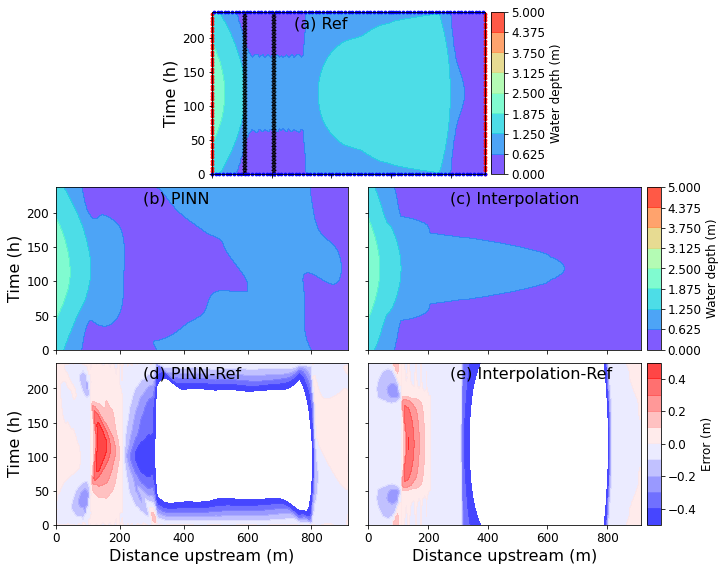

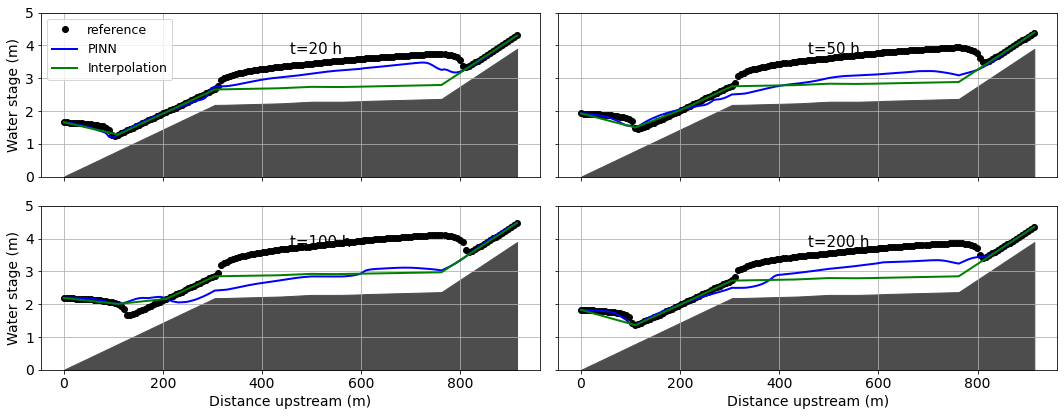

In [13]:
H = np.arange(len(Model_time[:Nt]))
x = x[::-1]  #reverse the channel
x4, t4 = np.meshgrid(x.flatten(), H)

# List of variables to convert from feet to meters
variables_to_convert = [x4, x, U_test,H_test, u_Pred, h_Pred, h_interp, E]
# Conversion factor
factor = 0.3048  
# Apply the conversion factor to all variables in the list
for i in range(len(variables_to_convert)):
    variables_to_convert[i] *= factor 


plt.rcParams.update({'font.size': 16})
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
fig = plt.figure(figsize=(10.5, 8))
gs = gridspec.GridSpec(3, 4, hspace=0.08, wspace=0.15)

levels = np.linspace(0, 5, 9)
levels_error = np.linspace(-0.5, 0.5, 11)

# Creating subplots
ax0 = create_subplot(fig, gs, 0, 1,3, '{} Ref'.format(labels[0]), levels, H_test[:Nt, :], 'rainbow', 'Water depth (m)', False,True,True)
ax0.scatter(X_Bc_u[:,0][::5]*factor, X_Bc_u[:,1][::5], marker='.', c='red', s=30, clip_on=False)
ax0.scatter(x[0][0]- x_Obs_h[::5]*factor, t_Obs_h[::5], facecolors='none', edgecolors='black', marker='*', s=20, clip_on=False)
ax0.scatter(X_Ic_h[:,0][::2]*factor, X_Ic_h[:,1][::2], marker='.', c='blue', s=30, clip_on=False)

ax1 = create_subplot(fig, gs, 1, 0,2, '{} PINN'.format(labels[1]), levels, h_Pred[:Nt, :], 'rainbow', None, False,True,False)
ax2 = create_subplot(fig, gs, 1, 2,4, '{} Interpolation'.format(labels[2]), levels, h_interp[:Nt, :], 'rainbow', 'Water depth (m)',False,False,True)
ax3 = create_subplot(fig, gs, 2, 0,2, '{} PINN-Ref'.format(labels[3]), levels_error, h_Pred[:Nt, :] - H_test[:Nt, :], 'bwr', None,True, True,False)
ax4 = create_subplot(fig, gs, 2, 2,4, '{} Interpolation-Ref'.format(labels[4]), levels_error, h_interp[:Nt, :] - H_test[:Nt, :], 'bwr', 'Error (m)',True,False,True)

# Adjusting the layout
plt.subplots_adjust(left=0.1, bottom=0.08, right=0.9, top=0.97, wspace=0.2, hspace=0.10)

# Save and display the plot
plt.savefig('contour.pdf')
plt.show()


t = [20, 50, 100, 200]
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)
labels = ['reference', 'PINN', 'Interpolation']

for k, ax in enumerate(axes.flat):
    ax.plot(x, H_test[t[k], :] + E, 'ok', label=labels[0])
    ax.plot(x, h_Pred[t[k], :] + E, '-b', linewidth=2, label=labels[1])
    ax.plot(x, h_interp[t[k], :] + E, '-g', linewidth=2, label=labels[2])
    ax.fill_between(x.flatten(), E, color='0.3')
    ax.text(0.5, 0.75, f't={int(t[k])} h', fontsize=15, transform=ax.transAxes)
    if k in [0, 2]:
        ax.set_ylabel('Water stage (m)')
    ax.set_ylim([0, 5])
    ax.grid()
    if k in [2, 3]:
        ax.set_xlabel('Distance upstream (m)')
    if k == 0:
        ax.legend(loc=2, prop={'size': 12.5})

# Tight layout and save the figure
plt.tight_layout()
plt.savefig('along_channel.pdf')
plt.show()
plt.close()
        
